## TensorFlow 2.x

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
from sklearn.preprocessing import StandardScaler
data['normalizedAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data[['normalizedAmount', 'Amount']].head()

,normalizedAmount,Amount
0,0.244964,149.62
1,-0.342475,2.69
2,1.160686,378.66
3,0.140534,123.50
4,-0.073403,69.99


In [4]:
# Examine the Class values
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Undersampling

In [5]:
# Undersample data
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
temp = data.sample(frac=1)
class1 = temp.loc[temp['Class'] == 1]
class0 = temp.loc[temp['Class'] == 0][:class1.shape[0]]

# udf = undersample dataframe
udf = pd.concat([class1, class0]).sample(frac=1)
print(udf.shape)
print(udf['Class'].value_counts())

(984, 32)
1    492
0    492
Name: Class, dtype: int64


In [6]:
uX = udf.drop(['Time', 'Amount', 'Class'], axis=1)
uy = udf['Class']

In [7]:
from sklearn.model_selection import train_test_split
uX_train, uX_test, uy_train, uy_test = train_test_split(uX, uy, test_size = 0.3)
print(uX_train.shape)
print(uX_test.shape)

(688, 29)
(296, 29)


In [8]:
# Create the model
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
inputs = uX_train.shape[1]
layers = inputs * 2

# umodel = model for undersampled data
umodel = Sequential()
umodel.add(Dense(layers, kernel_initializer='uniform', activation='relu', input_dim=inputs))
umodel.add(Dense(inputs, activation='relu'))
umodel.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.01)
umodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(umodel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 58)                1740      
_________________________________________________________________
dense_1 (Dense)              (None, 29)                1711      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 30        
Total params: 3,481
Trainable params: 3,481
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# Create earlystopping callback
earlystopping = EarlyStopping(monitor = 'val_loss',
                             min_delta = 0,
                             patience = 5,
                             verbose = 1,
                             restore_best_weights = True)

callbacks = [earlystopping]
uhistory = umodel.fit(uX_train,
                     uy_train,
                     epochs = 25,
                     verbose = 1,
                     validation_data = (uX_test, uy_test),
                     callbacks = callbacks)

Train on 688 samples, validate on 296 samples
Epoch 1/25
688/688 [==============================] - 0s 262us/sample - loss: 0.2814 - accuracy: 0.8692 - val_loss: 0.2077 - val_accuracy: 0.9189
Epoch 2/25
688/688 [==============================] - 0s 55us/sample - loss: 0.1450 - accuracy: 0.9520 - val_loss: 0.1741 - val_accuracy: 0.9324
Epoch 3/25
688/688 [==============================] - 0s 55us/sample - loss: 0.1272 - accuracy: 0.9666 - val_loss: 0.1738 - val_accuracy: 0.9257
Epoch 4/25
688/688 [==============================] - 0s 53us/sample - loss: 0.0874 - accuracy: 0.9709 - val_loss: 0.1702 - val_accuracy: 0.9257
Epoch 5/25
688/688 [==============================] - 0s 54us/sample - loss: 0.0684 - accuracy: 0.9797 - val_loss: 0.2474 - val_accuracy: 0.9291
Epoch 6/25
688/688 [==============================] - 0s 55us/sample - loss: 0.0705 - accuracy: 0.9782 - val_loss: 0.2163 - val_accuracy: 0.9291
Epoch 7/25
688/688 [==============================] - 0s 50us/sample - loss: 0.0525

In [11]:
uscore = umodel.evaluate(uX_test, uy_test)
print('Test loss: ', uscore[0])
print('Test accuracy: ', uscore[1])

296/296 [==============================] - 0s 20us/sample - loss: 0.1702 - accuracy: 0.9257
Test loss:  0.17018820471256166
Test accuracy:  0.9256757


In [12]:
# Get predictions
upredictions = umodel.predict(uX_test).round()

[[131   7]
 [ 15 143]]

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       138
           1       0.95      0.91      0.93       158

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296



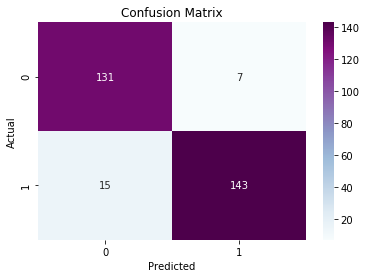

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(uy_test, upredictions)
print(cm)
print()
cr = classification_report(uy_test, upredictions)
print(cr)
sn.heatmap(cm, annot=True, cmap='BuPu', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Oversampling

In [14]:
from imblearn.over_sampling import SMOTE

# o = oversample
oX = data.drop(['Time', 'Amount', 'Class'], axis=1)
oy = data['Class']
oversample = SMOTE()
oX, oy = oversample.fit_resample(oX, oy)
print(oy.value_counts())

Using TensorFlow backend.


1    284315
0    284315
Name: Class, dtype: int64


In [15]:
oX_train, oX_test, oy_train, oy_test = train_test_split(oX, oy, test_size = 0.3)
print(oX_train.shape)
print(oX_test.shape)

(398041, 29)
(170589, 29)


In [16]:
# Create the model
inputs = oX_train.shape[1]
layers = inputs * 2

omodel = Sequential()
omodel.add(Dense(layers, kernel_initializer='uniform', activation='relu', input_dim=inputs))
omodel.add(Dense(inputs, activation='relu'))
omodel.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.01)
omodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(omodel.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 58)                1740      
_________________________________________________________________
dense_4 (Dense)              (None, 29)                1711      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 30        
Total params: 3,481
Trainable params: 3,481
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
ohistory = omodel.fit(oX_train,
                     oy_train,
                     epochs=25,
                     verbose=1,
                     validation_data=(oX_test, oy_test),
                     callbacks=callbacks)

Train on 398041 samples, validate on 170589 samples
Epoch 1/25
398041/398041 [==============================] - 22s 55us/sample - loss: 0.0226 - accuracy: 0.9933 - val_loss: 0.0262 - val_accuracy: 0.9938
Epoch 2/25
398041/398041 [==============================] - 22s 55us/sample - loss: 0.0106 - accuracy: 0.9976 - val_loss: 0.0087 - val_accuracy: 0.9978
Epoch 3/25
398041/398041 [==============================] - 22s 55us/sample - loss: 0.0098 - accuracy: 0.9981 - val_loss: 0.0118 - val_accuracy: 0.9983
Epoch 4/25
398041/398041 [==============================] - 22s 54us/sample - loss: 0.0092 - accuracy: 0.9984 - val_loss: 0.0052 - val_accuracy: 0.9992
Epoch 5/25
398041/398041 [==============================] - 22s 54us/sample - loss: 0.0100 - accuracy: 0.9984 - val_loss: 0.0152 - val_accuracy: 0.9976
Epoch 6/25
398041/398041 [==============================] - 22s 55us/sample - loss: 0.0097 - accuracy: 0.9986 - val_loss: 0.0179 - val_accuracy: 0.9982
Epoch 7/25
397376/398041 [==========

In [ ]:
oscore = omodel.evaluate(oX_test, oy_test)
print('Oversampled test loss: ', oscore[1])
print('Oversampled test accuracy: ', oscore[0])
print('Compared with')
print('Undersampled test loss: ', uscore[1])
print('Undersampled test accuracy: ', uscore[0])

In [ ]:
# Get predictions
opredictions = omodel.predict(oX_test).round()

In [ ]:
# Compare confusion matrix and classification reports
ocm = confusion_matrix(oy_test, opredictions)
ocr = classification_report(oy_test, opredictions)
print('Undersampled Confusion Matrix')
print(cm)
print('Oversampled Confusion Matrix')
print(ocm)
print()
print('Undersampled Classification Report')
print(cr)
print('Oversampled Classification Report')
print(ocr)